In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import glob
import os
from scipy.signal.windows import tukey
import json
from IPython.display import display, Math
%matplotlib notebook

# 1)

To shift an array f(x) by an arbitrary amount, we can take its FFT and multiply it by a phase ramp vector $exp(-2\pi i k m/N)$, where $m$ is the length of the shift measured in indices. Hence, when we take the inverse FFT, we get the following:

$$IFFT(exp(-2\pi i k m/N) \cdot FFT( f(x)))$$
$$ =\frac{1}{N} \sum_{x=0}^{N-1}( exp(-2\pi i k m/N)  \sum_{x=0}^{N-1} f(x) exp(-2\pi i k x/N)) exp(2\pi i k x/N)$$
$$ = \frac{1}{N} \sum_{x=0}^{N-1} \sum_{x=0}^{N-1} f(x) exp(-2\pi i k (x-m)/N) exp(2\pi i k x/N)$$

Now if we do a change of variable $x \rightarrow x-m$, this reduces to:

$$IFFT(FFT(f(x-m)) = f(x-m)$$

In [2]:
def shifting(array,shift):
    N = len(array)
    array_ft = np.fft.fft(array)
    k = np.arange(N)
    phase_ramp = np.exp(-2*np.pi*1j*k*shift/N)
    shifted = np.fft.ifft(phase_ramp*array_ft)
    return shifted

In [3]:
x = np.linspace(0,10,1001)
std = 1
cent_gauss = np.exp(-0.5*(x-np.median(x))**2/std**2)

<IPython.core.display.Javascript object>


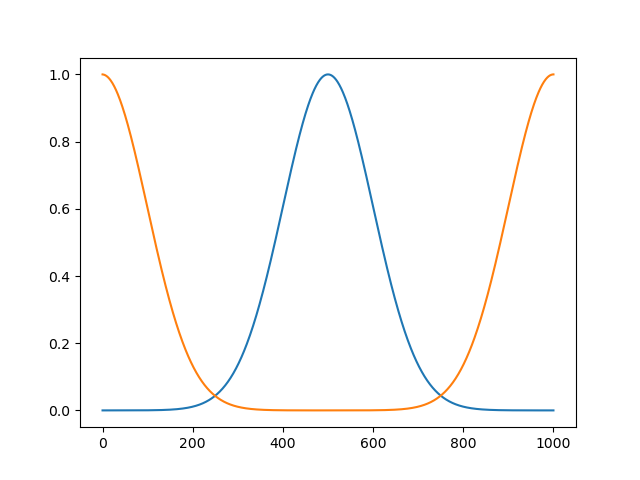

In [4]:
plt.figure()
plt.plot(np.abs(cent_gauss))
shifted_gauss = shifting(cent_gauss,len(cent_gauss)//2)
plt.plot(np.abs(shifted_gauss))

We see that the originally centered Gaussian has been shifted by half the array length, it loops back to the beginning of the array when it goes over the edge of it, due to the periodic nature of FFTS.

# 2)

## a)
To write a correlation routine is straightforward: we take the FFT of each array, multiply them together while taking the conjugate of one of them, and take the inverse FFT of that product.

In [5]:
def correlation(array1,array2):
    array1_ft, array2_ft = np.fft.fft(array1), np.fft.fft(array2)
    corr = np.fft.ifft(array1_ft*np.conj(array2_ft))
    return corr

<IPython.core.display.Javascript object>


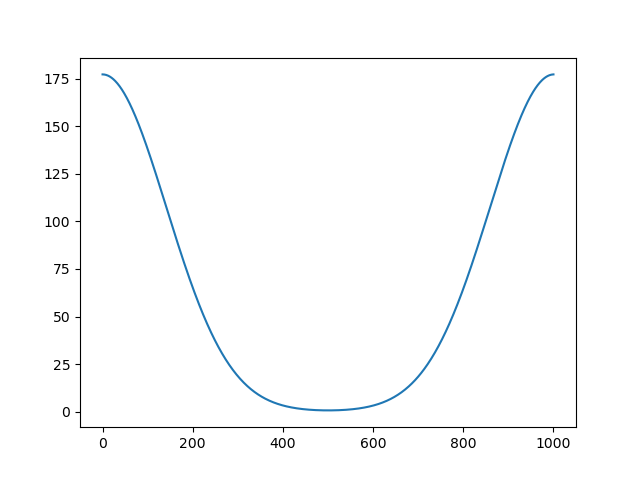

In [6]:
autocorr_gauss = correlation(cent_gauss,cent_gauss)
plt.figure()
plt.plot(np.abs(autocorr_gauss))

This result is what we expect. Taking the correlation of an array with itself starts at a maximum (when both arrays are fully overlapping, then as we "slide" the two arrays against each other, the overlap of the area between the two arrays drops down and comes back up to the maximum when we have done a "full loop" of the arrays against eachother.

## b)

We can use these two function to take the correlation of a gaussian with its shifted analog. Just take the gaussian, shift it, and correlate both of those arrays.

In [7]:
def corr_shifted_gaussian(gauss,shift):
    shifted_gauss = shifting(gauss,shift)
    corr = correlation(gauss,shifted_gauss)
    return corr

<IPython.core.display.Javascript object>


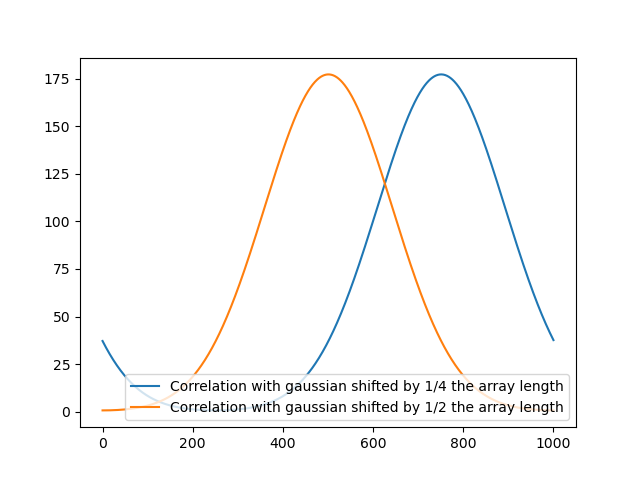

In [8]:
corr_gauss_shiftgauss_quarter = corr_shifted_gaussian(cent_gauss,len(cent_gauss)//4)
corr_gauss_shiftgauss_half = corr_shifted_gaussian(cent_gauss,len(cent_gauss)//2)
plt.figure()
plt.plot(np.abs(corr_gauss_shiftgauss_quarter), label = 'Correlation with gaussian shifted by 1/4 the array length')
plt.plot(np.abs(corr_gauss_shiftgauss_half), label = 'Correlation with gaussian shifted by 1/2 the array length')
plt.legend(loc = 'lower right')

Again, this result was expected, as the correlation of a gaussian with itself is the gaussian itself, the correlation is always the same, but it is shifted by some amount. Hence, the correlation amplitude does not depend on the shift. Only the phase does.

# 3)

To have no problems with the wrapping nature, we can pad the start of an array and the end of the other with zeros. To be certain that the non-wrapping information will be where we want it, we need to add as many zeros as there are entries in the arrays. Then, we take only the first half of the convolution. Now, when taking a convolution of a gaussian with itself, we should only see a falloff, and no rise as we don't want the information of when the arrays wrap around back into each other.

In [9]:
def convolution_nowrap(array1,array2):
    array1_w0s = np.hstack((array1,np.zeros(len(array1))))
    array2_w0s = np.hstack((np.zeros(len(array2)),array2))
    
    a1_ft,a2_ft = np.fft.fft(array1_w0s),np.fft.fft(array2_w0s)
    conv = np.fft.ifft(a1_ft*a2_ft)
    return conv[:len(conv)//2]

In [10]:
conv = convolution_nowrap(cent_gauss,cent_gauss)

<IPython.core.display.Javascript object>


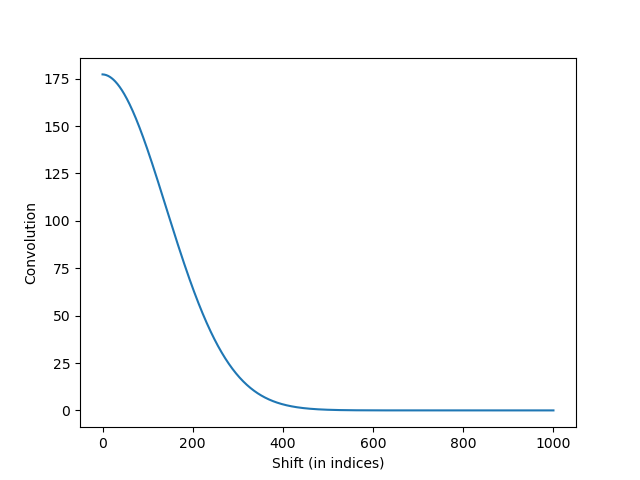

Text(0.5, 0, 'Shift (in indices)')

In [11]:
plt.figure()
plt.plot(np.abs(conv))
plt.ylabel('Convolution')
plt.xlabel('Shift (in indices)')

This corresponds to what we want.

# 4)


## a)

$$ \sum_{x=0}^{N-1} exp(-2 \pi i k x/N) = \sum_{x=0}^{N-1} \alpha^x $$

Where $\alpha = exp(-2 \pi i k /N)$, we can now treat this as a geometric series:

$$ s = \sum_{x=0}^{N-1} \alpha^x$$

$$ \alpha s = \sum_{x=1}^{N} \alpha^x $$

$$ s-\alpha s = \alpha^0-\alpha^N$$

$$ s = \frac{\alpha^0-\alpha^N}{1-\alpha}$$

$$ s = \frac{1-exp(-2 \pi i k )}{1-exp(-2 \pi i k /N)}$$

## b)

By l'Hospital's rule:

$$ \lim_{k\to 0} \frac{1-exp(-2 \pi i k )}{1-exp(-2 \pi i k /N)} = \lim_{k\to 0} \frac{2 \pi i exp(-2 \pi i k) }{2 \pi i /N exp(-2 \pi i k /N)} = \frac{1}{1/N} = N$$

If k is not a multiple of N, but is an integer, the denominator is $1-exp(-2\pi i a)$, where a is not an integer, and the numerator is $1-exp(-2\pi i k) = 0$. the numerator is 0 and the denominator is non-zero, so $s=0$.

However, if $k$ is an integer multiple of $N$ ($k=nN$), the denominator is $1-exp(-2\pi i n ) = 1-exp(-2\pi i)$, and we have the case from the limit above so $s=N$.

## c)

Let $f(x) = sin(x) = \frac{exp(ik_nx)-exp(-ik_nx)}{2i}$, where $k_n$ is a non-integer wave number for the sine wave.

We want to compute $$F(K) = \sum_{x=0}^{N-1} f(x) exp(-2 \pi i k x/N)$$

$$F(K) = \sum_{x=0}^{N-1} \frac{exp(ik_nx)-exp(-ik_nx)}{2i} exp(-2 \pi i k x/N)$$

$$ = \sum_{x=0}^{N-1} \frac{1}{2i} (exp(-2 \pi i k x/N+ik_nx)-exp(-2 \pi i k x/N-ik_nx))$$

$$ =  \frac{1}{2i} [\sum_{x=0}^{N-1} exp(-2 \pi i k x/N+ik_nx)-\sum_{x=0}^{N-1} exp(-2 \pi i k x/N-ik_nx))]$$

We can treat each of these sums as geometric series like in a), which yields:

$$ F(k) = \frac{1}{2i} [\frac{1-exp(i(k_nN-2\pi k))}{1-exp(i(k_n-2\pi k/N))}-\frac{1-exp(-i(k_nN-2\pi k))}{1-exp(-i(k_n-2\pi k/N))}]$$

This will be our analytic estimation of $F(k)$, Let us now compare the analytic and numerical DFTs

In [12]:
def analytic_sin_dft(wvnum,N):
    k = np.arange(N)
    term1 = (1-np.exp(1j*(wvnum*N-2*np.pi*k)))/(1-np.exp(1j*(wvnum-2*np.pi/N*k)))
    term2 = np.conj(term1)
    return 1/(2j)*(term1-term2)

In [13]:
k = 3/2
N = 10000
analytic_dft = analytic_sin_dft(k,N)
x = np.arange(N)
y = np.sin(k*x)
yft = np.fft.fft(y)

<IPython.core.display.Javascript object>


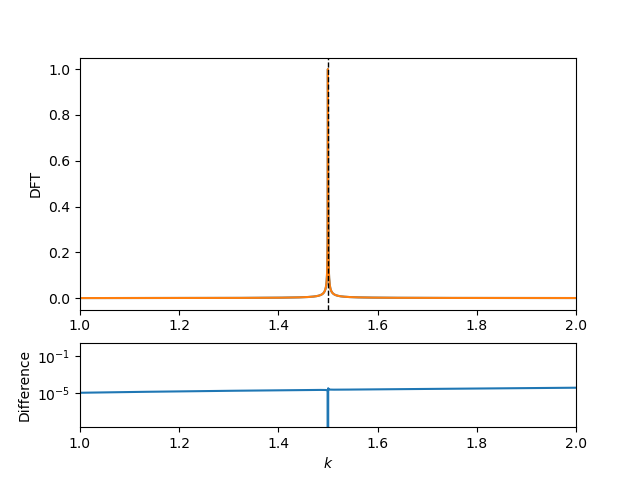

Text(0, 0.5, 'DFT')

In [14]:
fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]})
analytic_dft_norm = np.abs(analytic_dft)/np.max(np.abs(analytic_dft))
yft_norm = np.abs(yft)/np.max(np.abs(yft))
ks = 2*np.pi/N*np.arange(N)
ax[0].plot(ks,analytic_dft_norm,label = 'Analytic')
ax[0].plot(ks,yft_norm,label = 'Numerical')
ax[0].axvline(k,linestyle = '--',linewidth = 1,color = 'k')
ax[0].set_xlim(1,2)
ax[1].semilogy(ks,np.abs(analytic_dft_norm-yft_norm))
ax[1].set_xlim(1,2)
ax[1].set_xlabel(r'$k$')
ax[1].set_ylabel('Difference')
ax[0].set_ylabel('DFT')

We see that they agree pretty well, not exactly up to machine precision, except at the peak. It also looks pretty close to a delta function, but not exactly. Note that the numerical FFT produces two spikes, corresponding to positive and negative frequencies, so I renormalized both transforms such that the highest peaks are of unity, and concentrated only on the peak of the numerical FFT that corresponds with positive frequencies.

# d)

Let us multiply the original signal by the window function $W(x) = \frac{1}{2}-\frac{1}{2}cos(2\pi x /N)$

In [15]:
def window(x):
    return 1/2-1/2*np.cos(2*np.pi*x/len(x))

<IPython.core.display.Javascript object>


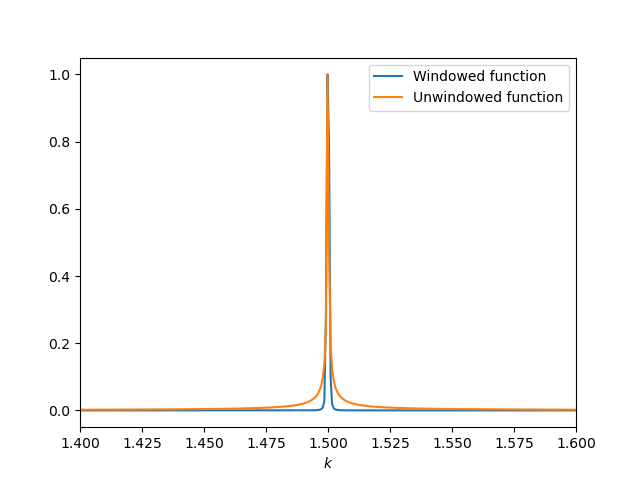

Text(0.5, 0, '$k$')

In [16]:
win = window(x)
y_win = win*y
y_winft = np.fft.fft(np.fft.fftshift(y_win))
plt.figure()
y_winft_norm = np.abs(y_winft)/np.max(np.abs(y_winft))
plt.plot(ks,y_winft_norm,label = 'Windowed function')
plt.plot(ks,yft_norm,label = "Unwindowed function")
plt.legend()
plt.xlim(1.4,1.6)
plt.xlabel(r'$k$')

We see that the width of the peak is much smaller with the windowed function: the leakage has dropped.

# e)

We can show what is the transform of the window, here we shift the array such that the non-zero coefficients are in the middle, and we can see them side-by-side.

<IPython.core.display.Javascript object>


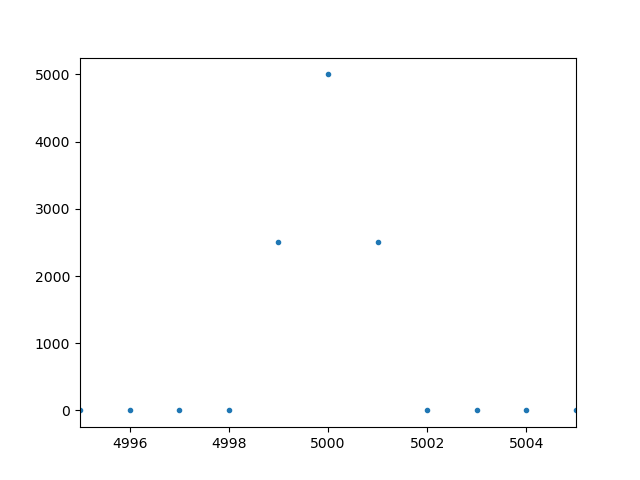

(4995.0, 5005.0)

In [17]:
winft = np.fft.fft(win)
plt.figure()
plt.plot(np.abs(np.fft.fftshift(winft)),'.')
plt.xlim(4995,5005)

In [18]:
display(Math('$ F(0) = {}$'.format(np.abs(winft[0]))))
display(Math('$ F(1) = {}$'.format(np.abs(winft[1]))))
display(Math('$ F(N) = {}$'.format(np.abs(winft[-1]))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

We had 10000 points in our window, and the only non-zero modes in the FFT of the window are indeed $F(0)$,$F(1)$, and $F(N)$, which are $N/2$,$N/4$ and$ N/4$ respectively. Doing this is effectively the same as having a moving $1-2-1$ weigted average of the spectrum.  This is because we are multiplying the window and signal in real space, we are convoluting in Fourier space. Convoluting with a Fourier transform that looks like the one above is the same as doing the moving average. However, we need to be careful with the signs, the analytic Fourier transform tells us that the coefficients of the modes $1$ and $N$ are negative:

$$W(x) = \frac{1}{2}-\frac{1}{2}cos(\frac{2\pi x}{N})$$
$$W(x) = \frac{1}{2}-\frac{1}{4}exp(i\frac{2\pi x}{N})+exp(-i\frac{2\pi x}{N}))$$
$$W(x) = \frac{1}{N}[\frac{N}{2}-\frac{N}{4}exp(i\frac{2\pi x}{N})+exp(-i\frac{2\pi x}{N}))]$$
In the brackets, we can read off the FFT, the first term is the $k=0$ mode, the second one is the $k=1$ mode, and the third one is the $k = -1$ mode, but since we are doing an IFFT, this is like the $k = N$ mode. Hence, we see that the coefficients are respectively $\frac{N}{2},-\frac{N}{4} and -\frac{N}{4}$ for the $k=0,1,N$.

<IPython.core.display.Javascript object>


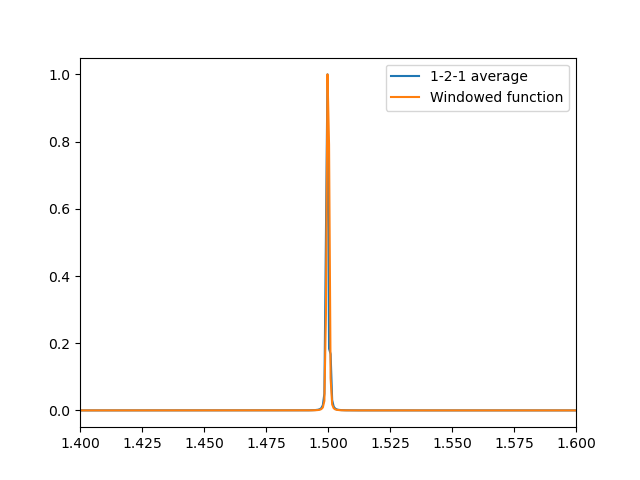

In [19]:
def moving_avg(array):
    averaged = array.copy()
    for i in range(len(array)-1):
        averaged[i] = -array[i-1]/4-array[i+1]/4+array[i]/2
    averaged[-1] =  -array[-2]/4-array[0]/4+array[-1]/2
    return averaged

win_equiv = np.abs(moving_avg(yft_norm))
plt.figure()
win_equiv_norm = win_equiv/np.max(win_equiv)
plt.plot(ks,win_equiv_norm,label = '1-2-1 average')
plt.plot(ks,y_winft_norm,label = 'Windowed function')
plt.xlim(1.4,1.6)
plt.legend()

We see that the spectra now overlap

# 5)

First, using the functions provided to read the data and templates, let's look at the time series for each event at each detector, and then at each template.

In [20]:
def read_template(filename):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    tp=template[0]
    tx=template[1]
    return tp,tx
def read_file(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    #gpsStart=meta['GPSstart'].value
    gpsStart=meta['GPSstart'][()]
    #print meta.keys()
    #utc=meta['UTCstart'].value
    utc=meta['UTCstart'][()]
    #duration=meta['Duration'].value
    duration=meta['Duration'][()]
    #strain=dataFile['strain']['Strain'].value
    strain=dataFile['strain']['Strain'][()]
    dt=(1.0*duration)/len(strain)

    dataFile.close()
    return strain,dt,utc

Here, we just order the data files such that the templates correspond to their events later on. It's ugly but I didn't want to write something that went through the dictionary... this will work for now.

In [21]:
path = 'Ligo_data/'
fnames_L_unordered=glob.glob(path+"L-*.hdf5")
fnames_H_unordered=glob.glob(path+"H-*.hdf5")
fnames_H = [0]*len(fnames_H_unordered)
fnames_L = [0]*len(fnames_L_unordered)
fnames_H[0] = fnames_H_unordered[1]
fnames_L[0] = fnames_L_unordered[1]
fnames_H[1] = fnames_H_unordered[3]
fnames_L[1] = fnames_L_unordered[3]
fnames_H[2] = fnames_H_unordered[0]
fnames_L[2] = fnames_L_unordered[0]
fnames_H[3] = fnames_H_unordered[2]
fnames_L[3] = fnames_L_unordered[2]

L_events = []
for fname in fnames_L:
    L_events.append(read_file(fname))
    

H_events = []
for fname in fnames_H:
    H_events.append(read_file(fname))

<IPython.core.display.Javascript object>


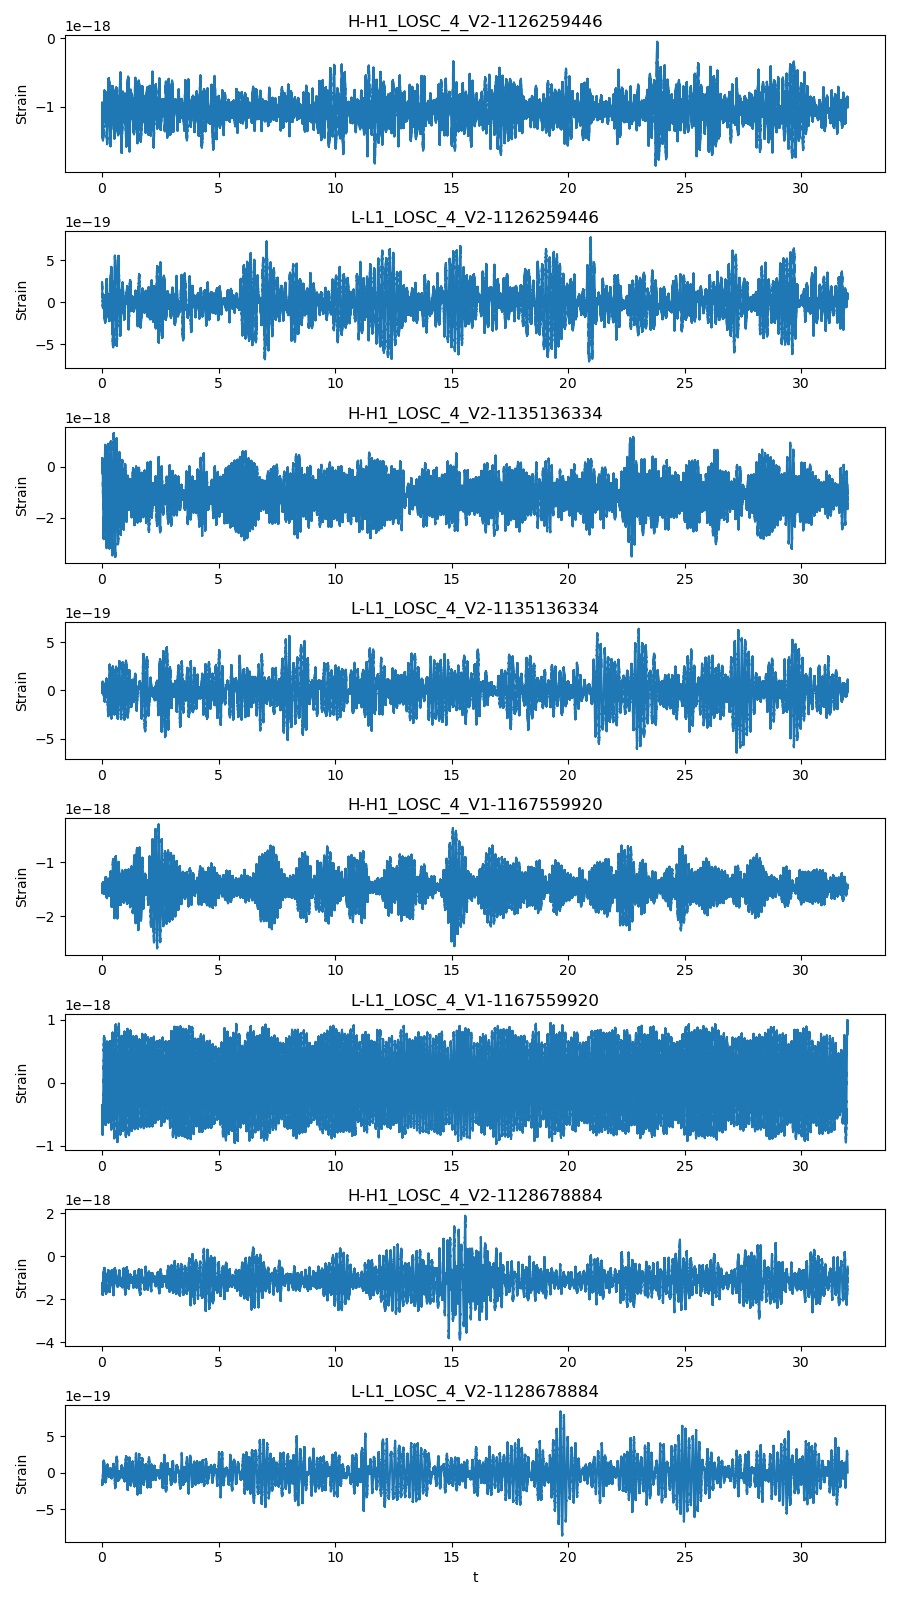

In [22]:
fig, ax = plt.subplots(len(L_events)+len(H_events),1,figsize = (9,len(H_events)*4))

for i in range(len(L_events)):
    strain,dt,utc = L_events[i]
    t = np.arange(len(strain))*dt
    ax[2*i].plot(t,strain)
    ax[2*i].set_ylabel('Strain')
    ax[2*i].set_title(fnames_H[i][10:-8])
for i in range(len(H_events)):
    strain,dt,utc = H_events[i]
    t = np.arange(len(strain))*dt
    ax[2*i+1].plot(t,strain)
    ax[2*i+1].set_ylabel('Strain')
    ax[2*i+1].set_title(fnames_L[i][10:-8])
ax[-1].set_xlabel('t')
    
fig.tight_layout()

In [23]:
fnames=glob.glob(path+"*template.hdf5")
templates = []
for fname in fnames:
    templates.append(read_template(fname))

<IPython.core.display.Javascript object>


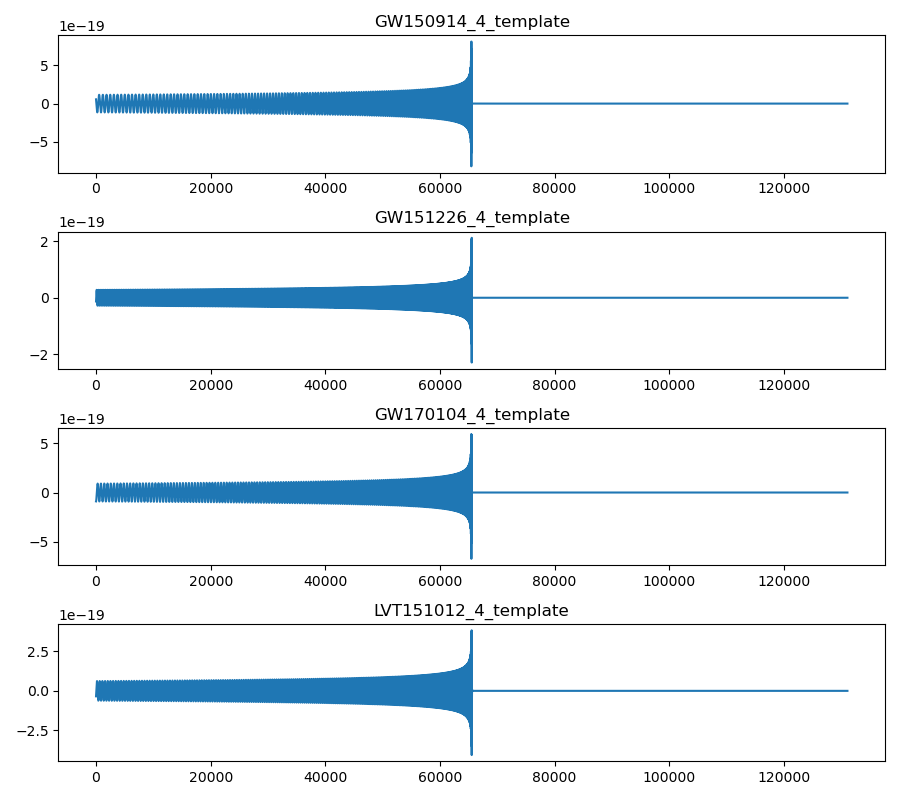

In [24]:
fig, ax = plt.subplots(len(templates),1,figsize = (9,len(templates)*2))

for i in range(len(templates)):
    tp,tx = templates[i]
    ax[i].plot(tp)
    ax[i].set_title(fnames[i][10:-5])
    
fig.tight_layout()

## a)

To come up with a noise model, we assume that our data is almost exclusively noise. We then take the power spectrum of each event, and take that as the noise model. We will also average it over all events, dor each detector separately, therefore, we are more confident that the features related to the signal itself will get averaged away, and we will be left with noise features only. 

In [25]:
H_noises = []

for i in range(len(H_events)):
    win = tukey(len(H_events[i][0]))
    noise = np.abs(np.fft.rfft(win*H_events[i][0]))
    H_noises.append(np.abs(noise)**2)
H_noise = np.mean(H_noises, axis = 0)

L_noises = []

for i in range(len(L_events)):
    win = tukey(len(L_events[i][0]))
    noise = np.abs(np.fft.rfft(win*L_events[i][0]))
    L_noises.append(np.abs(noise)**2)
L_noise = np.mean(L_noises, axis = 0)

<IPython.core.display.Javascript object>


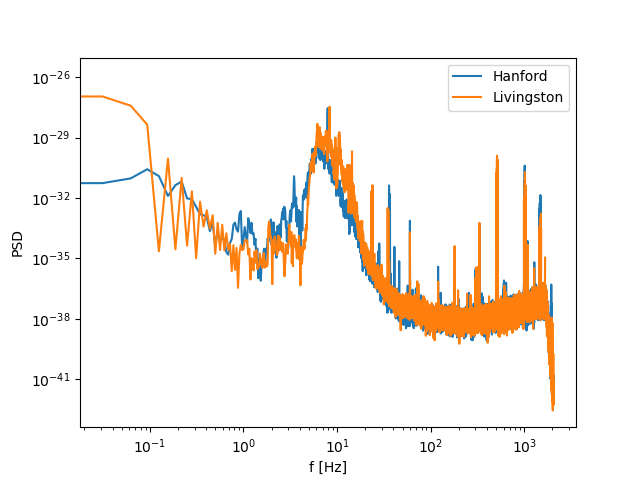

Text(0, 0.5, 'PSD')

In [26]:
fs = np.fft.rfftfreq(len(templates[i][0]),dt)
plt.figure()
plt.loglog(fs,H_noise,label = 'Hanford')
plt.loglog(fs,L_noise,label = 'Livingston')
plt.legend()
plt.xlabel('f [Hz]')
plt.ylabel('PSD')

We will now smooth the noise, using the smoothing function shown in class. This function effectively takes the noise array and convolves it with a gaussian filter, which has the effect of removing all the small jitters in the power spectrum, but also broadens all features.

In [27]:
def smooth_vector(vec,sig):
    n=len(vec)
    x=np.arange(n)
    x[n//2:]=x[n//2:]-n
    kernel=np.exp(-0.5*x**2/sig**2) #make a Gaussian kernel
    kernel=kernel/kernel.sum()
    vecft=np.fft.rfft(vec)
    kernelft=np.fft.rfft(kernel)
    vec_smooth=np.fft.irfft(vecft*kernelft) #convolve the data with the kernel
    return vec_smooth

In [28]:
H_noise_smooth = smooth_vector(H_noise,10)
L_noise_smooth = smooth_vector(L_noise,10)

<IPython.core.display.Javascript object>


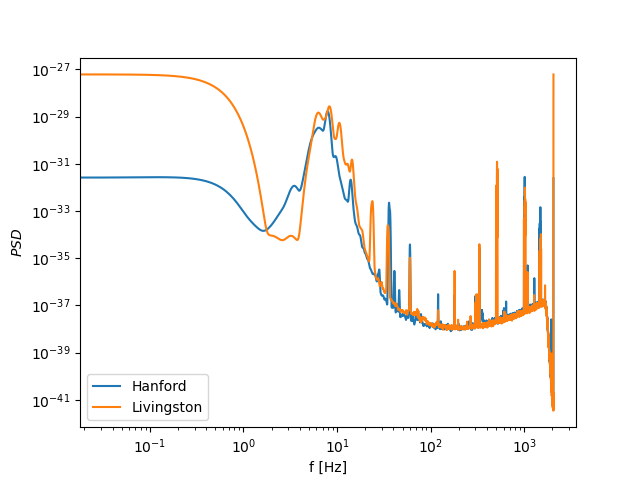

In [29]:
plt.figure()
plt.loglog(fs[:-1],np.abs(H_noise_smooth),label = 'Hanford')
plt.loglog(fs[:-1],np.abs(L_noise_smooth),label = 'Livingston')
plt.xlabel('f [Hz]')
plt.ylabel(r'$PSD$')
plt.legend()

We can compute our $N^{-1}$ matrix from there. However, we will set our entries of that matrix to 0 if we are above 1500 Hz or below 20Hz, because we cannot understand the noise from outside these bounds. Therefore, we will not use the frequencies components coming from outside these bounds when performing our match filter.

In [30]:
Ninv_L,Ninv_H = 1/L_noise_smooth,1/H_noise_smooth
Ninv_L[fs[:-1]>1500],Ninv_H[fs[:-1]>1500]=0,0
Ninv_L[fs[:-1]<20],Ninv_H[fs[:-1]<20]=0,0

## b)-c)

Now, we perform a match filter, which is basically a way of performing a least-squares fit for every possible shift between our data and our templates. So we want to perform our usual operations $m = (A^TN^{-1}A)^{-1}(A^TN^{-1}d)$ where A is the template, N is the noise matrix, and d is our data, for every possible overlap of the data and template. However, N is not diagonal in this case because we have stationary noise. We then want to write our least squares fit in a space where N is diagonal, in other words, we want to pre whiten our data and template. for no shift, this looks like the following:

$$m = (A^TN^{-1}A)^{-1}(A^TN^{-1}d)$$
$$m = (A^TN^{-1/2}IN^{-1/2}A)^{-1}(A^TN^{-1/2}IN^{-1/2}d)$$
$$m = (((N^{-1/2})^TA)^TIN^{-1/2}A)^{-1}(((N^{-1/2})^TA)^TIN^{-1/2}d)$$

But $(N^{-1/2})^T = N^{-1/2}$ because stationary noise is symmetric
$$m = ((N^{-1/2}A)^TIN^{-1/2}A)^{-1}((N^{-1/2}A)^TIN^{-1/2}d)$$
$$m= (\tilde{A}^TI\tilde{A})^{-1}(\tilde{A}^TI\tilde{d})$$

Where $\tilde{M} = N^{-1/2}M$ and is the pre-whitened array

Now, we have an expression for our least-squares fit where we can use our noise model to perform our fit as usual. We still need to do it for every possible shift of the data and template so

$$m(\tau) = (\tilde{A}(t-\tau)^T\tilde{A}(t-\tau))^{-1}(\tilde{A}(t-\tau)^T\tilde{d}(t))$$

So using a cross-correlation, we can retreive our match filter as a function of time, which is 

$$ MF(t) = IFFT(FFT(\tilde{A})^*\times FFT(\tilde{d}))$$


We repeat this for every event and every detector, using the corresponding template. We can then estimate the noise by taking the absolute value of the time series of the MFs. Because the match filter is mostly noise except at the detection time, this will give us an estimate of the scatter in the non-detection part of the filter. We can then compute the SNR by taking the ratio between the max amplitude of the filter and the noise estimate. All of this is reported in the figure below.

<IPython.core.display.Javascript object>


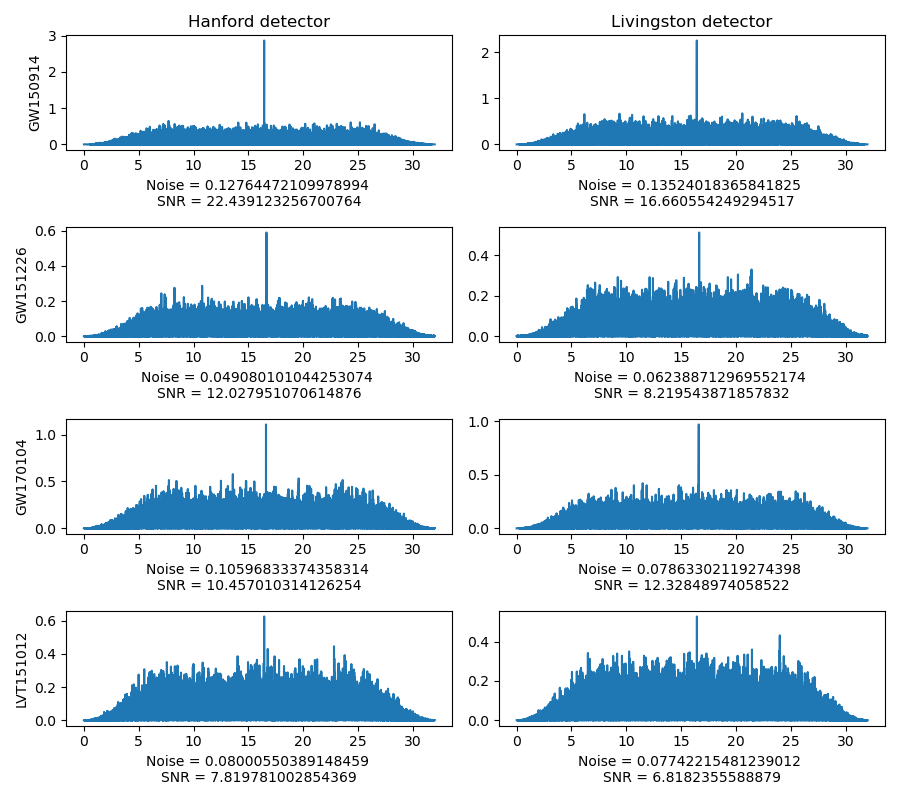

In [31]:
fig,ax = plt.subplots(len(L_events),2,figsize = (9,8))

comb_SNRs = np.zeros(len(H_events))
opt_SNRs = np.zeros(len(H_events))
H_mfs = []
L_mfs = []


for i in range(len(H_events)):
    ax[i][0].set_ylabel(fnames[i][10:-16]) 
    
    H_strain = H_events[i][0]
    L_strain = L_events[i][0]
    
    t = H_events[i][1]*np.arange(len(H_strain))
    
    H_strainft = np.fft.rfft(win*H_strain)
    L_strainft = np.fft.rfft(win*L_strain)
    
    tp = templates[i][0]
    tpft = np.fft.rfft(tp*win)
    H_tp_filtered = tpft[:-1]*np.sqrt(Ninv_H)
    L_tp_filtered = tpft[:-1]*np.sqrt(Ninv_L)
    
    H_mf = np.abs(np.fft.fftshift(np.fft.irfft(np.conj(H_tp_filtered)*H_strainft[:-1]*np.sqrt(Ninv_H))))
    L_mf = np.abs(np.fft.fftshift(np.fft.irfft(np.conj(L_tp_filtered)*L_strainft[:-1]*np.sqrt(Ninv_H))))
    
    H_mfs.append(H_mf)
    L_mfs.append(L_mf)
    
    ax[i][0].plot(t[:-2],H_mf)
    ax[i][1].plot(t[:-2],L_mf)
    
    H_noise_est = np.mean(H_mf[len(H_mf)//4:-len(H_mf)//4])
    L_noise_est = np.mean(L_mf[len(L_mf)//4:-len(L_mf)//4])
    
    H_SNR = np.max(np.abs(H_mf))/H_noise_est
    L_SNR = np.max(np.abs(L_mf))/L_noise_est
    
    ax[i][0].set_xlabel('Noise = {} \nSNR = {}'.format(H_noise_est,H_SNR))
    ax[i][1].set_xlabel('Noise = {} \nSNR = {}'.format(L_noise_est,L_SNR))
    
    comb_SNRs[i] = (H_SNR+L_SNR)/2
    TP_adj = tp[::2]
    opt_SNRs_H = np.max(np.fft.irfft(np.conj(H_tp_filtered)*H_tp_filtered))**0.5
    opt_SNRs_L = np.max(np.fft.irfft(np.conj(L_tp_filtered)*L_tp_filtered))**0.5
    opt_SNRs[i] = 0.5*(opt_SNRs_H+opt_SNRs_L)
       
    
    
ax[0][0].set_title('Hanford detector')
ax[0][1].set_title('Livingston detector')
fig.tight_layout()    

## d)

In the for loop above, we also computed the ideal SNR given our templates and noise, that is, what would be the SNR given that our pre whitened templates were exactly representative of the signals. The analytical SNR would then be $\frac{A^TA}{\sqrt{A^TA}} = \sqrt{A^TA}$. In our case, our noise is not the identity matrix, so we have to account for that and use the pre-whitened template so our optimal SNR is $\sqrt{\tilde{A}^T\tilde{A}} = \sqrt{A^TN^{-1}A}$. We repeat this for each event and each detector, and we take the mean of both the SNR from the scatter in the MFs and the analytical SNR for each event, which yields the following:

In [32]:
for i in range(len(comb_SNRs)):
    print('Event {}:\n'.format(fnames[i][10:-16]))
    print('combined SNR from scatter in MF =  {}'.format(comb_SNRs[i]))
    print('optimal SNR =  {}'.format(opt_SNRs[i]))
    print('\n')

Event GW150914:

combined SNR from scatter in MF =  19.54983875299764
optimal SNR =  46.689677443208126


Event GW151226:

combined SNR from scatter in MF =  10.123747471236353
optimal SNR =  19.09940477472321


Event GW170104:

combined SNR from scatter in MF =  11.392750027355737
optimal SNR =  38.06738594509822


Event LVT151012:

combined SNR from scatter in MF =  7.3190082808711345
optimal SNR =  29.452963258083848




We see that the SNR from the scatter in the MFs is considerably smaller than the optimal SNRs, which makes sense, as the templates used cannot be exact representations of the physical events. For the event GW121226, we hit about 1/2 of the optimal SNR, which means that this event had the most accurate template. 

# e)

We now want to determine the frequency of each event. To do so, we can take the cumulative sum of the power spectrum of each pre-whitened template. Looking at the power spectrum of the pre-whitened templates tell us what frequency components we are effectively looking for in the data. Taking the cumulative sum of that spectrum tells us "how much" of the filtered template we are reconstructing by adding up frequency components up to this frequency. Therefore, we can look at where this cumulative sum hits its halfway point, the frequency corresponding to that point is the frequency for which half of the weight is above, and half of the weight is below.

<IPython.core.display.Javascript object>


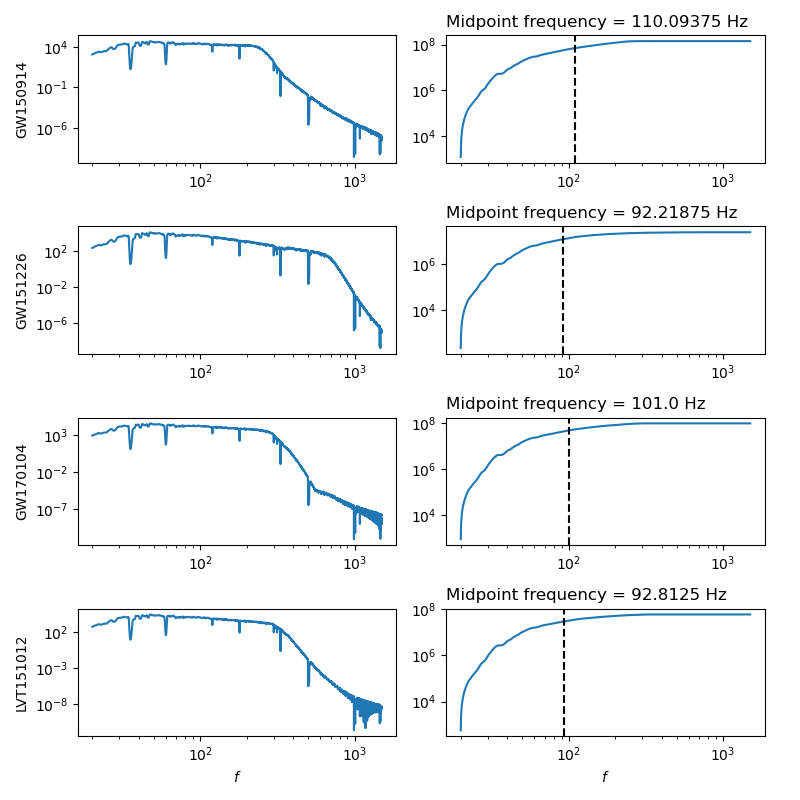

In [33]:
fig, ax = plt.subplots(len(templates),2,figsize = (8,8))

for i in range(len(templates)):
    
    tp = templates[i][0]
    tpft = np.fft.rfft(tp*win)
    tp_filtered = tpft[:-1]*np.sqrt(np.mean([Ninv_L,Ninv_H],axis = 0))

    ps = np.abs(tp_filtered)**2
    ps2 = ps[ps!=0]
    fs2 = fs[:-1][ps!=0]
    ax[i][0].loglog(fs2,ps2)
    ps_cumsum = np.cumsum(ps2)
    ax[i][1].loglog(fs2,ps_cumsum)
    mid = ps_cumsum[-1]/2
    diff = np.abs(ps_cumsum-mid)
    idx = np.where(diff==np.min(diff))
    ax[i][1].axvline(fs2[idx],linestyle = '--',c='k')
    ax[i][1].set_title('Midpoint frequency = {} Hz'.format(fs2[idx][0]),loc = 'left')
    ax[i][0].set_ylabel(fnames[i][10:-16])
ax[-1][0].set_xlabel('$f$')
ax[-1][1].set_xlabel('$f$')
fig.tight_layout()

# f)

To get an uncertainty on the detection time, we look at the width of the peak of the match filter. The 1-$\sigma$ uncertainty corresponds to half the width of the peak when it drops below its maximum minus the estimate of the noise for that match filter. The peak is generally asymmetrical, but we take the mean of the upper and lower limit to get an estimate. This gives an estimate of the error in the detection time for an individual detector. The time delay between both detectors is simply $\Delta t = |t_H-t_L|$. We can get the error on the time delay, $\sigma_{\Delta t} = \sqrt{\sigma_{t,H}^2+\sigma_{t,L}^2}$ Then, we know that the angle that the source makes with the vertical is $\theta = arcsin(\frac{c\Delta t}{D})$, where c is the speed of light, and D is the distance between the detectors. We propagate  the error through the derivative method and get that $$\sigma_{\theta} = \frac{c\Delta t}{D} \frac{1}{\sqrt{1-(\frac{c\sigma_{\Delta t}}{D})^2}}$$

To get the typical uncertainty, we here average over all time delays and time delay errors. The plot shows an example on the upper and lower 1-$\sigma$ limits for the Hanford events.

<IPython.core.display.Javascript object>


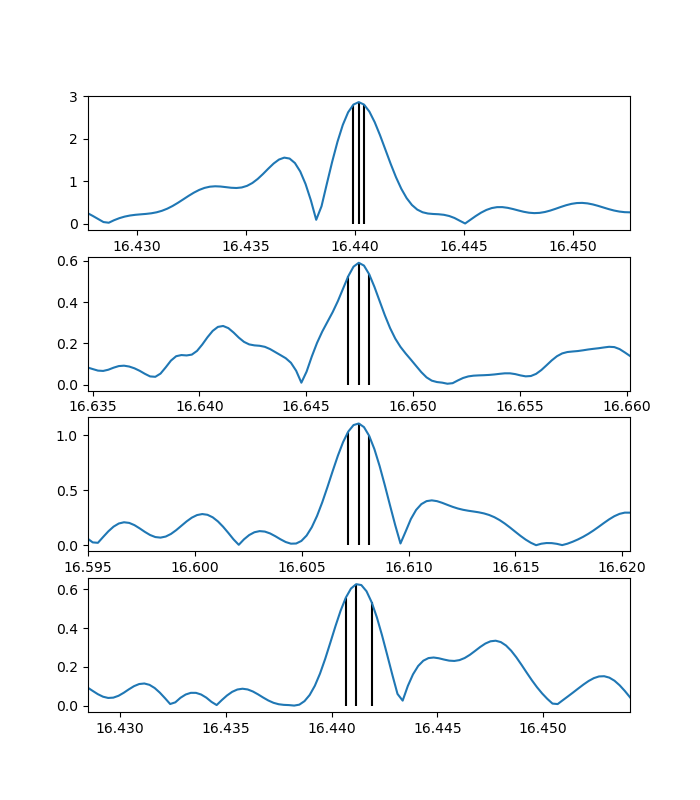

In [34]:
fig, ax = plt.subplots(len(H_mfs),1,figsize = (7,8))

deltats = np.zeros(len(H_mfs))
deltats_err = np.zeros(len(H_mfs))
for i in range(len(H_mfs)):
    H_idx = np.where(np.abs(H_mfs[i])==np.max(np.abs(H_mfs[i])))[0][0]
    L_idx = np.where(np.abs(L_mfs[i])==np.max(np.abs(L_mfs[i])))[0][0]
    
    AH = np.abs((np.abs(H_mfs[i][H_idx:])-(np.max(np.abs(H_mfs[i]))-H_noise_est)))
    AL = np.abs((np.abs(L_mfs[i][L_idx:])-(np.max(np.abs(H_mfs[i]))-H_noise_est)))
    BH = np.abs((np.abs(H_mfs[i][:H_idx])-(np.max(np.abs(H_mfs[i]))-L_noise_est)))
    BL = np.abs((np.abs(L_mfs[i][:L_idx])-(np.max(np.abs(H_mfs[i]))-L_noise_est)))
    
    H_up_idx = np.where(AH==np.min(AH))[0][0]+H_idx
    L_up_idx = np.where(AL==np.min(AL))[0][0]+L_idx

    H_low_idx = np.where(BH==np.min(BH))[0][0]
    L_low_idx = np.where(BL==np.min(BL))[0][0]
    
    deltats[i] = np.abs(t[H_idx]-t[L_idx])
    t_H_err = 0.5*(np.abs((t[H_up_idx]-t[H_idx]))+np.abs(t[H_low_idx]-t[H_up_idx]))
    t_L_err = 0.5*(np.abs((t[L_up_idx]-t[L_idx]))+np.abs(t[L_low_idx]-t[L_up_idx]))

    deltats_err[i] = np.sqrt(t_H_err**2+t_L_err**2)
    
    ax[i].plot(t[:-2],np.abs(H_mfs[i]))
    ax[i].set_xlim(t[H_low_idx]-50*dt,t[H_up_idx]+50*dt)
    ax[i].vlines([t[H_idx],t[H_low_idx],t[H_up_idx]],0,[np.abs(H_mfs[i][H_idx]),np.abs(H_mfs[i][H_low_idx]),np.abs(H_mfs[i][H_up_idx])])

In [35]:
typ_err_dt = np.mean(deltats_err)
typ_dt = np.mean(deltats)

In [36]:
c = 3e8
D = 1e6
def arcsin_deriv(x):
    return (1-x**2)**(-0.5)

typ_err = typ_err_dt*c/D*arcsin_deriv(c*typ_dt/D)
print(r'The typical uncertainty on the angular position of the source with respect to the baseline is ~{} rad'.format(round(typ_err,1)))

The typical uncertainty on the angular position of the source with respect to the baseline is ~0.6 rad
